In [2]:
import os
import json
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

$ 
h^* := \frac{\nu_0}{U}; 
\quad 
F(\theta) := t_0(\theta)  - t_1(\theta)
$

$
h_0(\theta) = h^* (1+ F'(\theta))
$

$h^* F'' = - R \cdot(F + wF') \cdot  h^* (1+ F'(\theta)) \cdot (1 -  h^* (1+ F'(\theta)))$

Simplified equation: $F'' = - R \cdot(F + wF') \cdot  h^*(1-h^*)$

Characteristic: $r^2 + kwr + k =0, \quad k = R(1-h^*)$

$D = (kw)^2 - 4k$

$ w <= \frac{2}{\sqrt{Rh^*(1-h^*)}}: \quad h_0 - h^* \sim e^{-\frac{kw}{2} \theta}$ 

$w > \frac{2}{\sqrt{Rh^*(1-h^*)}}: \quad h_0 - h^* \sim e^{-\frac{kw - \sqrt{D}}{2}\theta}$

$x' = Ax$

$F'' = -Rh(1-h)(F + wF') = f(F, F')$

$\frac{\partial f}{F'}(0) = 3F'^2 -1  = -1$

$ F'' \approx F - F'$

In [3]:
t_0 = 1
t_1 = 2
R = 0.1
U = 4.5
h_opt = 2/U

k = R*(1-h_opt)

2/np.sqrt(k)

8.48528137423857

In [4]:
def decay(w):
    if w <= 2/np.sqrt(k):
        return -k*w/2
    else:
        return -(k*w - np.sqrt((k*w)**2 - 4*k))/2
    
# plt.plot(np.logspace(0, 2, 100), [decay(w) for w in np.logspace(0, 2, 100)], '-')
# plt.ylabel('expected decay')
# plt.xlabel('projection window')
# plt.semilogx()

In [5]:
w = 1

dt = 0.01
T = 250

In [6]:
def rhs(t, y):
    return [y[1], -R * (y[0] + w * y[1]) * (1 + y[1]) * (1 - h_opt*(1 + y[1]))]

def rhs_simp(t, y):
    return [y[1], -R * (y[0] + w * y[1]) * (1 - h_opt)]

ic = [t_0-t_1, 0.01/h_opt - 1]

sol = solve_ivp(rhs, (0, T), ic, max_step=dt)
sol_simp = solve_ivp(rhs_simp, (0, T), ic, max_step=dt)

In [7]:
# out_dir = 'dynamic-prediction-equilibria/out/replication/queue_derivative/run_0/'
out_dir = 'dynamic-prediction-equilibria/out/replication/medium_demand/run_3'
out_dir = 'dynamic-prediction-equilibria/out/replication/init_params/run_1'

params, dynamics, means = dict(), dict(), dict()

with open(os.path.join(out_dir, "run_data.json"), 'r') as f:
    run_data = json.load(f)
    params = run_data['run_parameters']
    dynamics = run_data['dynamics']
    means = run_data['means']
    
params

{'demand': 4.5,
 'initial_distribution': [[[0], 0.01], [[1], 0.99]],
 'reroute_interval': 0.01,
 'horizon': 250.0,
 'fitness': 'neg_proj_tt',
 'replication_coef': 0.1,
 'regularization': None,
 'regularization_coef': 1.0,
 'regularization_decay': 0.05,
 'window_size': 1.0}

In [8]:
inflow = np.array(dynamics['0']['inflow share']['values'])
d = np.array(dynamics['0']['travel time']['values']) - np.array(dynamics['1']['travel time']['values'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


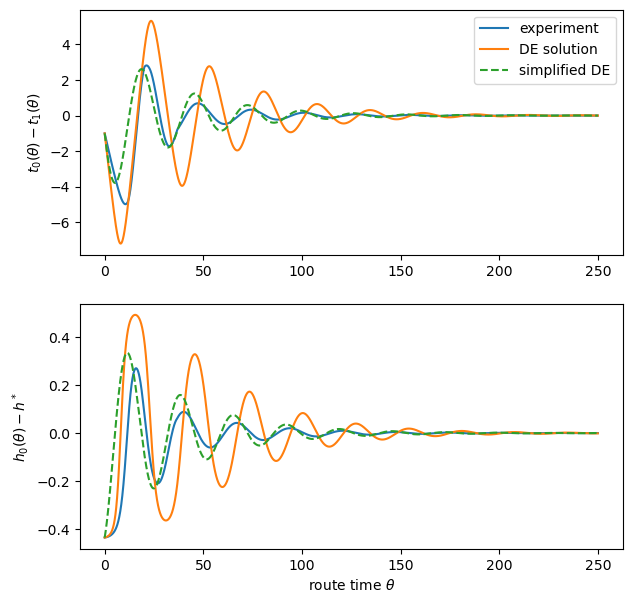

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7)) 

ax1.plot(dynamics['0']['travel time']['times'], d, '-', label='experiment')
ax1.plot(sol.t, sol.y[0,], label='DE solution')
ax1.plot(sol_simp.t, sol_simp.y[0,], '--', label='simplified DE')
# ax1.hlines(ic[0], 0, T, 'gray', '--')

ax2.plot(dynamics['0']['inflow share']['times'], (inflow - h_opt), '-', label='experiment')
ax2.plot(sol.t, h_opt*sol.y[1,], label='DE solution')
ax2.plot(sol_simp.t, h_opt*sol_simp.y[1,], '--', label='simplified DE')
# ax1.plot(sol.t, abs(ic[0])*np.exp(decay(w)*sol.t), '--', label='decay')
# ax2.hlines((U - 5)/2, 0, T, 'gray', '--')

ax1.set_ylabel(r'$t_0(\theta) - t_1(\theta)$')
ax2.set_ylabel(r'$h_0(\theta) - h^*$')
ax2.set_xlabel(r'route time $\theta$')
ax1.legend(bbox_to_anchor=(1,1))
# ax2.semilogy()

plt.savefig('de.eps', format='eps')

[]

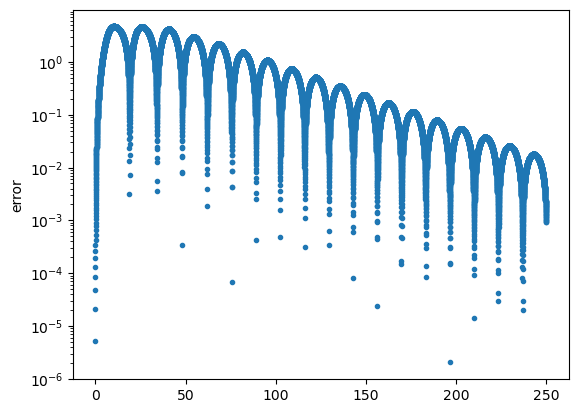

In [10]:
plt.plot(sol.t, np.abs(sol.y[0] - sol_simp.y[0]), '.')
plt.ylabel('error')
plt.semilogy()

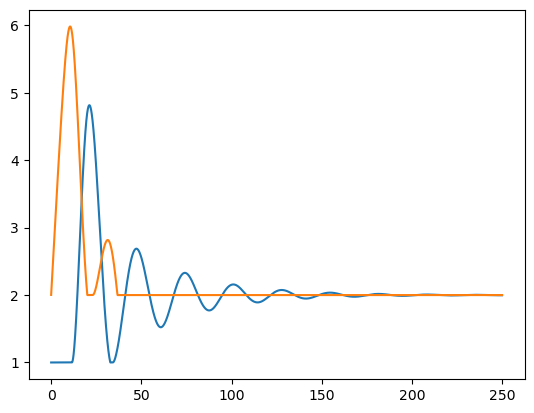

In [11]:
route_time = np.array(dynamics['0']['travel time']['times'])
tt_0 = np.array(dynamics['0']['travel time']['values'])
tt_1 = np.array(dynamics['1']['travel time']['values'])

plt.plot(route_time, tt_0)
plt.plot(route_time, tt_1)

In [21]:
q0 = tt_0 > 1 + 1e-10
q1 = tt_1 > 2 + 1e-10

cases = {1: q0 & q1, 2: q0 & ~q1, 3: ~q0 & q1}

In [22]:
"c3", (0, 11.47), (32.81, 34.15)
"c2", (20.07, 22.99), (36.78, 250)
"c1", (11.48, 20.06), (23.00, 32.80), (34.16, 36.77)

('c1', (11.48, 20.06), (23.0, 32.8), (34.16, 36.77))

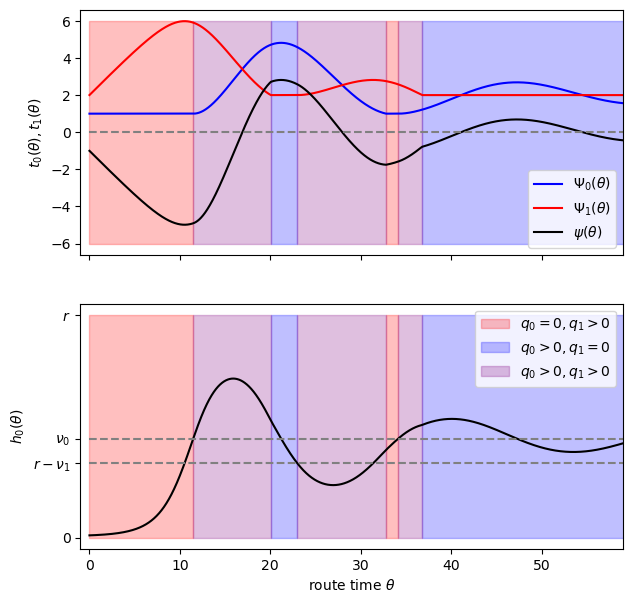

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7), sharex=True) 

ax1.plot(route_time, tt_0, 'blue', label=r'$\Psi_0(\theta)$')
ax1.plot(route_time, tt_1, 'red', label=r'$\Psi_1(\theta)$')
ax1.plot(route_time, tt_0 - tt_1, 'black', label=r'$\psi(\theta)$')
# ax1.plot(route_time, inflow*tt_0 + (1-inflow)*tt_1 , 'purple', '--' , label=r'$\overline{\Psi}$')

ax1.set_ylabel(r'$t_0(\theta), t_1(\theta)$')
ax1.hlines([0], 0, 100, 'gray', '--')
ax1.legend()

ax2.plot(route_time, inflow, 'black')
ax2.hlines([2/U, 1-3/U], 0, 100, 'gray', '--')
ax2.set_ylabel(r'$h_0(\theta)$')
ax2.set_xlabel(r'route time $\theta$')

ax2.set_yticks([0, 1 - 3/U, 2/U, 1], labels=['0', r'$r- \nu_1$', r'$\nu_0$', r'$r$'])
# ax2.text(0, 2/U+0.05, r'$h_0 = \frac{\nu_0}{U}$')
# ax2.text(0, 1 - 3/U-0.05, r'$\frac{\nu_1}{U}$')

alpha = 0.25

ax1.fill_betweenx([-6, 6], 20.07, 22.99, alpha=alpha, color='blue', label=r'$q_0 > 0, q_1 = 0$')
ax1.fill_betweenx([-6, 6], 36.78, 250, alpha=alpha, color='blue')

ax1.fill_betweenx([-6, 6], 0, 11.47, alpha=alpha, color='red', label=r'$q_0 = 0, q_1 > 0$')
ax1.fill_betweenx([-6, 6], 32.81, 34.15, alpha=alpha, color='red')

ax1.fill_betweenx([-6, 6], 11.48, 20.06, alpha=alpha, color='purple', label=r'$q_0 > 0, q_1 > 0$')
ax1.fill_betweenx([-6, 6], 23.00, 32.80, alpha=alpha, color='purple')
ax1.fill_betweenx([-6, 6], 34.16, 36.77, alpha=alpha, color='purple')

ax2.fill_betweenx([0, 1], 0, 11.47, alpha=alpha, color='red', label=r'$q_0 = 0, q_1 > 0$')
ax2.fill_betweenx([0, 1], 32.81, 34.15, alpha=alpha, color='red')

ax2.fill_betweenx([0, 1], 20.07, 22.99, alpha=alpha, color='blue', label=r'$q_0 > 0, q_1 = 0$')
ax2.fill_betweenx([0, 1], 36.78, 250, alpha=alpha, color='blue')

ax2.fill_betweenx([0, 1], 11.48, 20.06, alpha=alpha, color='purple', label=r'$q_0 > 0, q_1 > 0$')
ax2.fill_betweenx([0, 1], 23.00, 32.80, alpha=alpha, color='purple')
ax2.fill_betweenx([0, 1], 34.16, 36.77, alpha=alpha, color='purple')

ax2.set_xlim(-1, 59)
ax2.legend()

fig.savefig('phases.svg', format='svg', dpi=1200)

In [24]:
def inflow_potential_func(C, h_min):
    def F(h):
        return np.log(1/(1-h)) - h_min*np.log(h/(1-h))
    
    return lambda h: C*(F(h) - F(h_min))

C = {1: U/2+U/3, 2: U/2, 3: U/3}
h_min = {1: 2/(2+3), 2: 2/U, 3: 1-3/U}

color = {1: 'purple', 2: 'blue', 3: 'red'} 

# P = inflow_potential_func(C[1], h_min[1])(inflow)
P0 = inflow_potential_func(C[2], h_min[2])(inflow)
P1 = inflow_potential_func(C[3], h_min[3])(inflow)

Phi = tt_0 - tt_1
dot_Phi = sum(cases[i]*C[i]*(inflow - h_min[i]) for i in [1,2,3])

In [25]:
inflow_potential_func(C[2], h_min[2])(0.1)

0.8886221902223507

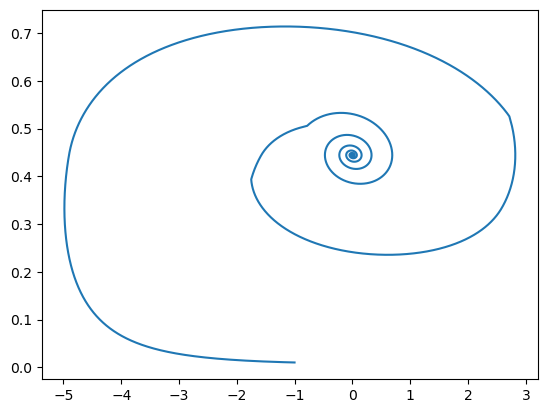

In [27]:
plt.plot(tt_0 - tt_1, inflow, '-')

Text(0, 0.5, '$\\dot{\\Phi}$')

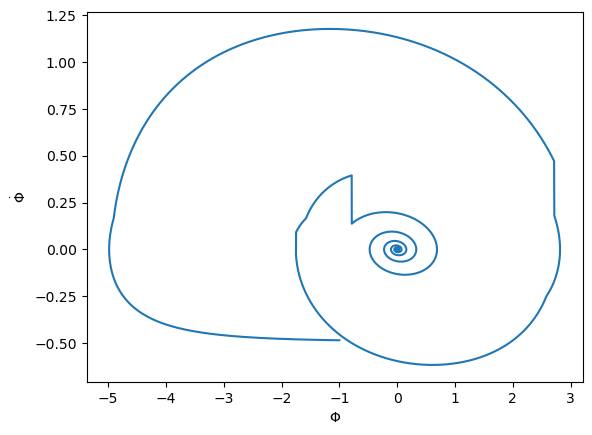

In [17]:
plt.plot(Phi, dot_Phi)
plt.xlabel(r'$\Phi$')
plt.ylabel(r'$\dot{\Phi}$')

$$\Pi_i(h) = \int_{h^{(i)}}^{h} \frac{ C_i ( h_0 - h^{(i)} )}{h_0(1-h_0)}dh_0 $$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


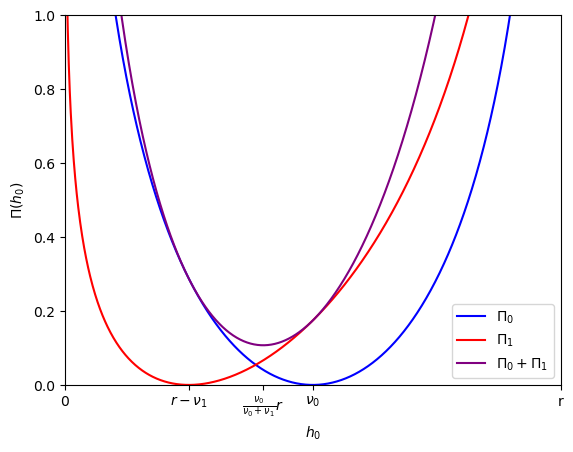

In [18]:
eps = 1e-5

r = 4


h = np.linspace(eps, 1-eps, num=1000)
P0 = inflow_potential_func(r/2, 2/r)(h)
P1 = inflow_potential_func(r/3, 1-3/r)(h)
plt.plot(h, P0, 'blue', label=r'$\Pi_0$')
plt.plot(h, P1, 'red', label=r'$\Pi_1$')
plt.plot(h, P0+P1, 'purple', label=r'$\Pi_0 + \Pi_1$')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel(r'$h_0$')
plt.ylabel(r'$\Pi(h_0)$')
plt.xticks([0, 2/r, 2/(2+3) ,1-3/r ,1], ['0', r'$\nu_0$' , r'$ \frac{\nu_0}{\nu_0 + \nu_1} r $', r'$r - \nu_1$' ,'r'])
plt.legend()
plt.savefig('potentials.eps', format='eps')

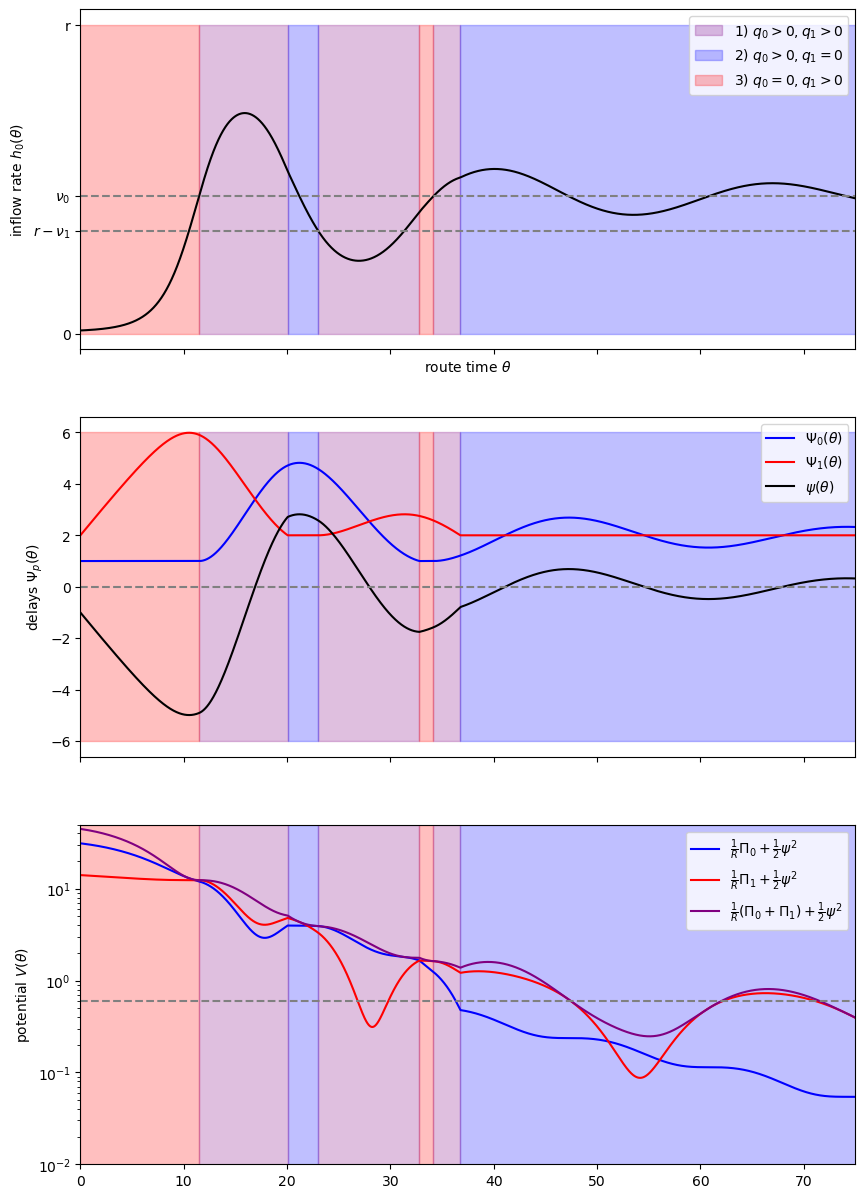

In [38]:
fig, (ax2, ax3, ax1) = plt.subplots(3, 1, figsize=(10,15), sharex=True) 

# ax1.plot(route_time, Phi**2/2, 'purple', label=r'$\frac{1}{2} \Phi^2$' )
ax1.plot(route_time, P0/R + Phi**2/2, 'blue', label=r'$\frac{1}{R} \Pi_0 + \frac{1}{2} \psi^2$' )
ax1.plot(route_time, P1/R + Phi**2/2, 'red', label=r'$\frac{1}{R} \Pi_1 + \frac{1}{2} \psi^2$' )
ax1.plot(route_time, (P0+P1)/R + Phi**2/2, 'purple', label=r'$\frac{1}{R}(\Pi_0 + \Pi_1) + \frac{1}{2} \psi^2$' )

# ax1.plot(route_time, Phi**2/2, 'black', '--', label=r'$\frac{1}{2} \Phi^2$' )
ax1.hlines([1/R*inflow_potential_func(U/2, 2/U)(1-3/U)], 0, 100, 'gray', '--')

ax1.set_ylabel(r'potential $V(\theta)$')
ax1.legend()
ax1.set_ylim(1e-2,50)
ax1.semilogy()

ax2.plot(route_time, inflow, 'black')
ax2.hlines([2/U, 1-3/U], 0, 100, 'gray', '--')
ax2.set_ylabel(r'inflow rate $h_0(\theta)$')
ax2.set_xlabel(r'route time $\theta$')
ax2.set_yticks([0, 1 - 3/U, 2/U, 1], labels=['0', r'$r -\nu_1$', r'$ \nu_0 $', 'r'])

# ax3.plot(route_time, C[1]*(inflow - h_min[1]), 'purple', label=r'$\dot{\Phi_1}$')
# ax3.plot(route_time, C[2]*(inflow - h_min[2]), 'blue', label=r'$\dot{\Phi_2}$')
# ax3.plot(route_time, C[3]*(inflow - h_min[3]), 'red', label=r'$\dot{\Phi_3}$')

# ax3.plot(route_time, dot_Phi, 'black', label=r'$\dot{\Phi}$')
# ax3.hlines([-(5-U)/2, (5-U)/2], 0, 100, 'gray', '--')
# ax3.hlines([0], 0, 100, 'gray')
# ax3.set_ylabel(r'$delay derivative \dot{\psi}(\theta)$')

# ax3.legend(loc='upper right')
# ax3.set_yticks([ -(5-U)/2, 0, (5-U)/2], labels=[ r'$-\frac{\nu_0 + \nu_1 - U}{\nu_0}$' ,'0', r'$\frac{\nu_0 + \nu_1 - U}{\nu_0}$'])

ax3.plot(route_time, tt_0, 'blue', label=r'$\Psi_0(\theta)$')
ax3.plot(route_time, tt_1, 'red', label=r'$\Psi_1(\theta)$')
ax3.plot(route_time, tt_0 - tt_1, 'black', label=r'$\psi(\theta)$')
# ax1.plot(route_time, inflow*tt_0 + (1-inflow)*tt_1 , 'purple', '--' , label=r'$\overline{\Psi}$')

ax3.set_ylabel(r'delays $\Psi_p(\theta)$')
ax3.hlines([0], 0, 100, 'gray', '--')
ax3.legend()


alpha = 0.25

ax1.fill_betweenx([0, 50], 0, 11.47, alpha=alpha, color='red')
ax1.fill_betweenx([0, 50], 32.81, 34.15, alpha=alpha, color='red')

ax1.fill_betweenx([0, 50], 20.07, 22.99, alpha=alpha, color='blue')
ax1.fill_betweenx([0, 50], 36.78, 250, alpha=alpha, color='blue')

ax1.fill_betweenx([0, 50], 11.48, 20.06, alpha=alpha, color='purple')
ax1.fill_betweenx([0, 50], 23.00, 32.80, alpha=alpha, color='purple')
ax1.fill_betweenx([0, 50], 34.16, 36.77, alpha=alpha, color='purple')

ax2.fill_betweenx([0, 1], 11.48, 20.06, alpha=alpha, color='purple', label=r'1) $q_0 > 0, q_1 > 0$')
ax2.fill_betweenx([0, 1], 23.00, 32.80, alpha=alpha, color='purple')
ax2.fill_betweenx([0, 1], 34.16, 36.77, alpha=alpha, color='purple')

ax2.fill_betweenx([0, 1], 20.07, 22.99, alpha=alpha, color='blue', label=r'2) $q_0 > 0, q_1 = 0$')
ax2.fill_betweenx([0, 1], 36.78, 250, alpha=alpha, color='blue')

ax2.fill_betweenx([0, 1], 0, 11.47, alpha=alpha, color='red', label=r'3) $q_0 = 0, q_1 > 0$')
ax2.fill_betweenx([0, 1], 32.81, 34.15, alpha=alpha, color='red')

ax3.fill_betweenx([-6, 6], 11.48, 20.06, alpha=alpha, color='purple', label=r'1) $q_0 > 0, q_1 > 0$')
ax3.fill_betweenx([-6, 6], 23.00, 32.80, alpha=alpha, color='purple')
ax3.fill_betweenx([-6, 6], 34.16, 36.77, alpha=alpha, color='purple')

ax3.fill_betweenx([-6, 6], 20.07, 22.99, alpha=alpha, color='blue', label=r'2) $q_0 > 0, q_1 = 0$')
ax3.fill_betweenx([-6, 6], 36.78, 250, alpha=alpha, color='blue')

ax3.fill_betweenx([-6, 6], 0, 11.47, alpha=alpha, color='red', label=r'3) $q_0 = 0, q_1 > 0$')
ax3.fill_betweenx([-6, 6], 32.81, 34.15, alpha=alpha, color='red')

ax2.legend()

plt.xlim(0,75)
fig.savefig('phases.png')

(0) -> (0,1) -> (1) -> (0,1) -> (0)
(1) -> (0,1) -> (0) -> 